In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
def get_datetime_id():
    return datetime.datetime.now().strftime('%h-%d-%y_%H-%M-00')

In [3]:
def plot_learning_curve(history_list,initial_epochs=0,fname_suffix=''):
    #initial_epochs == epoch start fine-tuning at

    acc = []
    val_acc = []
    val_loss = []
    loss = []
    for hist in history_list:
        loss += hist.history['loss'].copy()
        acc += hist.history['accuracy'].copy()
        val_loss += hist.history['val_loss'].copy()
        val_acc += hist.history['val_accuracy'].copy()

    fig = plt.figure(figsize=(6, 7))
    #plt.suptitle('MobileNetV2 Classifier Metrics by Epoch')

    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    if initial_epochs > 0:
        plt.plot([initial_epochs-1,initial_epochs-1],
                plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    if initial_epochs > 0:
        plt.plot([initial_epochs-1,initial_epochs-1],
                plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    fig.savefig(f'learning_large_mass_{fname_suffix}.png',dpi=300)
    return fig

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip files that we need

In [6]:
!unzip /content/drive/MyDrive/cbis-ddsm-zips/mass_only_large_contrast.zip -d /content/cbis-ddsm/


  inflating: /content/cbis-ddsm/train/MALIGNANT_MASS/1.3.6.1.4.1.9590.100.1.2.172077251111829320224994400042975972110-1.3.6.1.4.1.9590.100.1.2.122981719610620049441742166123385329893-abnorm_1.png  
  inflating: /content/cbis-ddsm/train/MALIGNANT_MASS/1.3.6.1.4.1.9590.100.1.2.68413432311143605442031343713253764295-1.3.6.1.4.1.9590.100.1.2.174614892811620217325392006831664307277-abnorm_1.png  
  inflating: /content/cbis-ddsm/train/MALIGNANT_MASS/1.3.6.1.4.1.9590.100.1.2.343454714212479210125169135872507321376-1.3.6.1.4.1.9590.100.1.2.144279124510995290217037531302453065227-abnorm_1.png  
  inflating: /content/cbis-ddsm/train/MALIGNANT_MASS/1.3.6.1.4.1.9590.100.1.2.361145064011340660209328710454053287988-1.3.6.1.4.1.9590.100.1.2.39470937012392746110917390223661128906-abnorm_1.png  
  inflating: /content/cbis-ddsm/train/MALIGNANT_MASS/1.3.6.1.4.1.9590.100.1.2.41260715312871650635748330381348737271-1.3.6.1.4.1.9590.100.1.2.286011332010675143839646470630879381008-abnorm_1.png  
  inflating:

In [8]:
IMG_SIZE = (128, 128)
IMG_SHAPE = (IMG_SIZE + (3,))
BATCH_SIZE = 100

In [9]:
data_dir = '/content/cbis-ddsm/train/'
ds_train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 1217 files belonging to 2 classes.


In [10]:
data_dir = '/content/cbis-ddsm/valid/'
ds_valid = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 101 files belonging to 2 classes.


In [11]:
data_dir = '/content/cbis-ddsm/test/'
ds_test = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 378 files belonging to 2 classes.


In [12]:
num_classes = len(ds_train.class_names)
BUFFER_SIZE = 250
STEPS_PER_EPOCH = 1318/BATCH_SIZE

In [13]:
train_dataset = ds_train.cache().shuffle(BUFFER_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
valid_dataset = ds_valid.cache()
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
test_dataset = ds_test.cache()
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# im,lb = next(iter(train_dataset))
# im.shape

Transfer Learning Binary Classification

In [17]:
BASE_MODEL_MODE = 2 # change this to 1 or 2

In [18]:
if BASE_MODEL_MODE == 1:
    # Create the base model from the pre-trained model MobileNet V2
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
    # Freeze convolution base
    base_model.trainable = False

    # go from 0,255 to -1,1
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
elif BASE_MODEL_MODE == 2:
    # Create base model using Xception
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        input_shape=IMG_SHAPE,
        include_top=False)
    # Freeze base model
    base_model.trainable = False

    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
else:
    raise ValueError("BASE_MODEL_MODE is not 1 or 2")

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, 0.1)),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1),width_factor=(-0.1, 0.1))
])
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

# Construct model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)
outputs = tf.keras.activations.sigmoid(x)
model = tf.keras.Model(inputs, outputs)

87916544/87910968 [==============================] - 1s 0us/step


Training last layer, fine-tuning, evaluate on test set

In [19]:
#####
# Train only last layer
#####
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy','AUC'])

initial_epochs = 100
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    callbacks=[early_stop])

#####
# Fine-tuning
#####
print("Start Fine Tuning")
base_model.trainable = True
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))
# # Fine-tune from this layer onwards
# fine_tune_at = 100
# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy','AUC'])


initial_epochs = len(history.history['loss']) # update intial_epochs if we did early stopping
fine_tune_epochs = 200
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset,
                         callbacks=[early_stop])


# Evaluate on Test Set
print("Evaluate on Test Set")
test_results = model.evaluate(test_dataset)
test_loss,test_accuracy,test_auc = test_results
print("Test loss, accuracy,auc :",test_results)

Epoch 1/100
13/13 [==============================] - 49s 380ms/step - loss: 0.9987 - accuracy: 0.4993 - auc: 0.4864 - val_loss: 0.6966 - val_accuracy: 0.5446 - val_auc: 0.6224
Epoch 2/100
13/13 [==============================] - 1s 82ms/step - loss: 0.7787 - accuracy: 0.6090 - auc: 0.6258 - val_loss: 0.6287 - val_accuracy: 0.6535 - val_auc: 0.7133
Epoch 3/100
13/13 [==============================] - 1s 74ms/step - loss: 0.7999 - accuracy: 0.5757 - auc: 0.5979 - val_loss: 0.5974 - val_accuracy: 0.7030 - val_auc: 0.7446
Epoch 4/100
13/13 [==============================] - 1s 82ms/step - loss: 0.7212 - accuracy: 0.6151 - auc: 0.6711 - val_loss: 0.5900 - val_accuracy: 0.7129 - val_auc: 0.7496
Epoch 5/100
13/13 [==============================] - 1s 73ms/step - loss: 0.7444 - accuracy: 0.6266 - auc: 0.6574 - val_loss: 0.5821 - val_accuracy: 0.7228 - val_auc: 0.7577
Epoch 6/100
13/13 [==============================] - 1s 78ms/step - loss: 0.7253 - accuracy: 0.5947 - auc: 0.6465 - val_loss: 0.

In [20]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_dataset)
y_pred = np.round(y_pred)

conf_mat = confusion_matrix(np.concatenate([y for _,y in test_dataset]), y_pred)
conf_mat

array([[181,  50],
       [ 49,  98]])

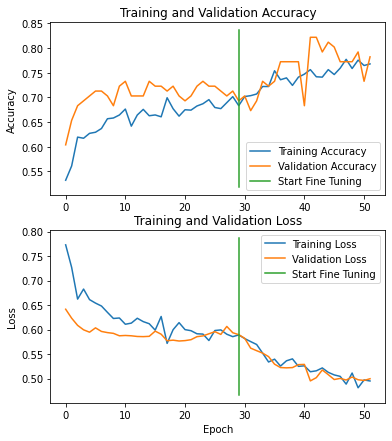

In [ ]:
fig=plot_learning_curve([history,history_fine],initial_epochs=initial_epochs,fname_suffix="full_aug")

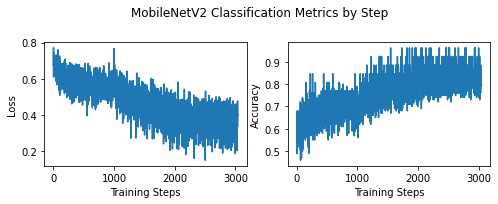

In [ ]:
fig2 = plt.figure(figsize=(8,5))
plt.suptitle('MobileNetV2 Classification Metrics by Step')

plt.subplot(2, 2, 1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.subplot(2, 2, 2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

fig2.savefig(f'training_by_steps{get_datetime_id()}.png',dpi=300)

Train from Scratch

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               
                                               include_top=False,
                                               weights=None) # use None for randomization

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])
# go from 0,255 to -1,1
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
#batch_stats_callback = CollectBatchStats()
initial_epochs = 200
history_baseline = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/200
20/20 [==============================] - 60s 961ms/step - loss: 0.6929 - accuracy: 0.5280 - val_loss: 0.6902 - val_accuracy: 0.5938
Epoch 2/200
20/20 [==============================] - 16s 761ms/step - loss: 0.6916 - accuracy: 0.5409 - val_loss: 0.6859 - val_accuracy: 0.5938
Epoch 3/200
20/20 [==============================] - 15s 771ms/step - loss: 0.6930 - accuracy: 0.5137 - val_loss: 0.6861 - val_accuracy: 0.5938
Epoch 4/200
20/20 [==============================] - 15s 761ms/step - loss: 0.6910 - accuracy: 0.5364 - val_loss: 0.6869 - val_accuracy: 0.5938
Epoch 5/200
20/20 [==============================] - 15s 763ms/step - loss: 0.6916 - accuracy: 0.5310 - val_loss: 0.6869 - val_accuracy: 0.5938
Epoch 6/200
20/20 [==============================] - 15s 769ms/step - loss: 0.6938 - accuracy: 0.5006 - val_loss: 0.6880 - val_accuracy: 0.5938
Epoch 7/200
20/20 [==============================] - 15s 760ms/step - loss: 0.6927 - accuracy: 0.5163 - val_loss: 0.6883 - val_accuracy: